In [60]:
1+1

2

In [7]:
!pwd

/Users/nadirgmira/code/carbon-forecast/notebooks


In [9]:
import sys
sys.path
sys.path.append('/Users/nadirgmira/code/carbon-forecast')

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns=500
pd.options.display.max_info_rows=550

from sklearn import set_config; set_config(display='diagram')
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.cluster import KMeans




In [38]:
from carbon_forecast.utils.preproc import load_n_preproc_all_avail
df = load_n_preproc_all_avail()
X = df.drop(columns=["company_name","year", "intensity_1and2","intensity_scope3",
                     "climate_strategy_score","disclosure","EV / Revenue","pe_rat"])
X=X.set_index('TCUID')

Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2013 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2013
-> intensity_scope2CY2013
-> intensity_scope3CY2013
-> Revenue2013
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees & EV per Revenue...
Filling null Climate Strategy Score with 0...
Cleaning P/E Ratio...
Adding Scope 1 and Scope 2 data together...
Doing some column renaming...
Filling in Disclosure...
Dataset preproc-ed for the year 2013!👍
Reading data...
Preproc on power % revenue
Preproc on Sector Revenue
Selecting the year 2014 required...
Dropping rows that are showing NaN on...
-> intensity_scope1CY2014
-> intensity_scope2CY2014
-> intensity_scope3CY2014
-> Revenue2014
Filling employee numbers with mean value... (subject to change later)
Filling EV with mean value... (subject to change later)
Calculating Employees 

In [61]:
len(X.columns)

454

In [39]:
X.head(3)

,Sector,Employees / Revenue,revenue,nuclear_percentage_revenue,thermal_coal_percentage_revenue,ultra_deep_sea_drilling_percentage_revenue,shale_oil_gas_percentage_revenue,coal_percentage_revenue,arctic_drilling_percentage_revenue,oil_sands_percentage_revenue,Abrasive product manufacturing,"Accounting, tax preparation, bookkeeping, and payroll services",Adhesive manufacturing,Advertising and related services,Air and gas compressor manufacturing,"Air conditioning, refrigeration, and warm air heating equipment manufacturing",Air purification and ventilation equipment manufacturing,Air transportation,Aircraft engine and engine parts manufacturing,Aircraft manufacturing,Alkalies and chlorine manufacturing,All other basic inorganic chemical manufacturing,All other chemical product and preparation manufacturing,All other converted paper product manufacturing,All other crop farming,All other food manufacturing,"All other forging, stamping, and sintering",All other miscellaneous electrical equipment and component manufacturing,All other miscellaneous manufacturing,"All other miscellaneous professional, scientific, and technical services",All other miscellaneous wood product manufacturing,All other paper bag and coated and treated paper manufacturing,All other petroleum and coal products manufacturing,All other textile product mills,All other transportation equipment manufacturing,Alumina refining and primary aluminum production,Aluminum product manufacturing from purchased aluminum,Ammunition manufacturing,"Amusement parks, arcades, and gambling industries",Analytical laboratory instrument manufacturing,"Animal (except poultry) slaughtering, rendering, and processing","Animal production, except cattle and poultry and eggs",Apparel accessories and other apparel manufacturing,Apparel knitting mills,"Apparel, Piece Goods, and Notions Wholesalers","Architectural, engineering, and related services","Arms, ordnance, and accessories manufacturing",Artificial and synthetic fibers and filaments manufacturing,Asphalt paving mixture and block manufacturing,Asphalt shingle and coating materials manufacturing,Audio and video equipment manufacturing,Automatic environmental control manufacturing,Automobile manufacturing,Automotive equipment rental and leasing,"Automotive repair and maintenance, except car washes",Ball and roller bearing manufacturing,Bare printed circuit board manufacturing,Bauxite Mining,Beet sugar manufacturing,Biological product (except diagnostic) manufacturing,Biomass Power Generation,Bituminous Coal Underground Mining,Bituminous Coal and Lignite Surface Mining,Blind and shade manufacturing,Boat building,Book publishers,Bowling centers,Bread and bakery product manufacturing,Breakfast cereal manufacturing,Breweries,"Brick, tile, and other structural clay product manufacturing",Broadcast and wireless communications equipment,Broadwoven fabric mills,"Broom, brush, and mop manufacturing",Building Material and Garden Equipment and Supplies Dealers,Business support services,Cable and other subscription programming,Car washes,Carbon and graphite product manufacturing,Carbon black manufacturing,Carpet and rug mills,Cattle ranching and farming,Cement manufacturing,Cheese manufacturing,Child day care services,Chocolate and confectionery manufacturing from cacao beans,Clay and nonclay refractory manufacturing,Clothing and Clothing Accessories Stores,Coal Power Generation,"Coated and laminated paper, packaging paper and plastics film manufacturing","Coating, engraving, heat treating and allied activities",Coffee and tea manufacturing,Commercial and industrial machinery and equipment rental and leasing,Commercial and industrial machinery and equipment repair and maintenance,Communication and energy wire and cable manufacturing,"Community food, housing, and other relief services, including rehabilitation services",Computer storage device manufacturing,Computer systems design services,Computer terminals and other computer peripheral equipment 

In [40]:
from carbon_forecast.utils.tx import our_tx
transformer = our_tx(X)
X_proc=transformer.fit_transform(X)

PCA

In [46]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_proc)
X_proj = pca.transform(X_proc)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1,X_proj.shape[1]+1)],index=X.index)

In [47]:
X_proj

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169,PC170,PC171,PC172,PC173,PC174,PC175,PC176,PC177,PC178,PC179,PC180,PC181,PC182,PC183,PC184,PC185,PC186,PC187,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201,PC202,PC203,PC204,PC205,PC206,PC207,PC208,PC209,PC210,PC211,PC212,PC213,PC214,PC215,PC216,PC217,PC218,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228,PC229,PC230,PC231,PC232,PC233,PC234,PC235,PC236,PC237,PC238,PC239,PC240,PC241,PC242,PC243,PC244,PC245,PC246,PC247,PC248,PC249,PC250,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300,PC301,PC302,PC303,PC304,PC305,PC306,PC307,PC308,PC309,PC310,PC311,PC312,PC313,PC314,PC315,PC316,PC317,PC318,PC319,PC320,PC321,PC322,PC323,PC324,PC325,PC326,PC327,PC328,PC329,PC330,PC331,PC332,PC333,PC334,PC335,PC336,PC337,PC338,PC339,PC340,PC341,PC342,PC343,PC344,PC345,PC346,PC347,PC348,PC349,PC350,PC351,PC352,PC353,PC354,PC355,PC356,PC357,PC358,PC359,PC360,PC361,PC362,PC363,PC364,PC365,PC366,PC367,PC368,PC369,PC370,PC371,PC372,PC373,PC374,PC375,PC376,PC377,PC378,PC379,PC380,PC381,PC382,PC383,PC384,PC385,PC386,PC387,PC388,PC389,PC390,PC391,PC392,PC393,PC394,PC395,PC396,PC397,PC398,PC399,PC400,PC401,PC402,PC403,PC404,PC405,PC406,PC407,PC408,PC409,PC410,PC411,PC412,PC413,PC414,PC415,PC416,PC417,PC418,PC419,PC420,PC421,PC422,PC423,PC424,PC425,PC426,PC427,PC428,PC429,PC430,PC431,PC432,PC433,PC434,PC435,PC436,PC437,PC438,PC439,PC440,PC441,PC442,PC443,PC444,PC445,PC446,PC447,PC448,PC449,PC450,PC451,PC452,PC453,PC454,PC455,PC456,PC457,PC458,PC459,PC460,PC461,PC462,PC463,PC464
TCUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
203522.0,-0.079605,-0.039105,0.045956,0.036544,0.097300,0.047265,0.233881,0.951692,-0.272872,-0.079894,-0.006892,-0.013633,-0.088378,-0.000400,-0.022062,-0.000484,0.001982,0.000566,-0.405383,0.008845,-0.010467,0.005078,-0.004764,0.013024,0.005901,-0.005669,0.183127,-0.284206,-0.078026,0.003203,0.004124,-0.017212,-0.018724,-0.011035,-0.025029,-0.002861,-0.005440,-0.000973,0.014100,0.005135,-0.002079,-0.018128,-0.021790,0.000083,-0.039774,0.068157,0.050260,0.153835,0.012877,0.002752,-0.024257,0.765318,0.008581,-0.044578,0.024746,0.004211,-0.001470,-0.012148,-0.003850,0.004105,0.005401,-0.002625,-0.100839,-0.007599,0.015588,0.000298,0.002884,-0.000272,-0.002512,-0.000120,-0.004039,0.001824,-0.003546,-0.012541,-0.006185,0.001274,0.017378,2.264458e-02,-0.001062,-0.019722,0.002093,-0.000447,-0.000058,-0.073893,-0.044224,0.017488,0.001658,0.030166,

(0.0, 30.0)

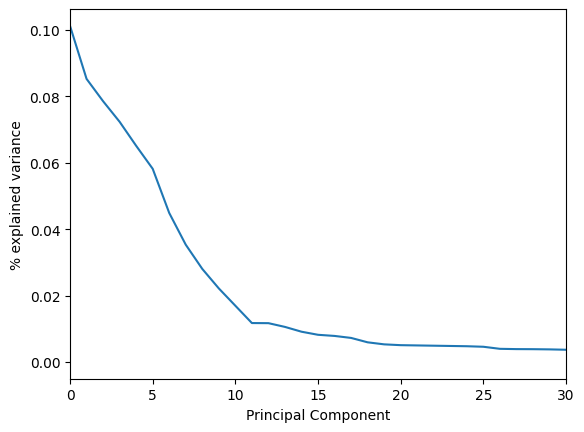

In [48]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');
plt.xlim(0,30)

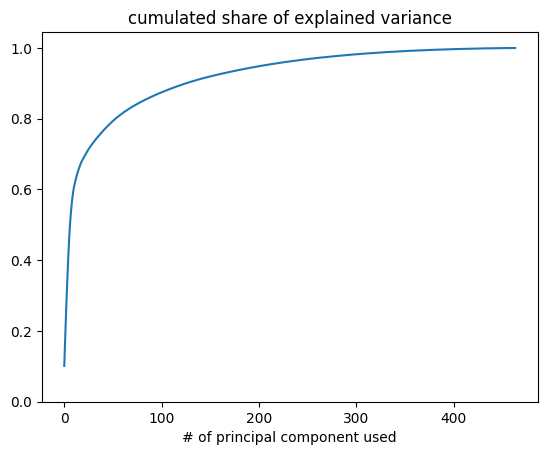

In [43]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [49]:

X_proj12 = PCA(n_components=12).fit_transform(X_proc)
X_proj12= pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1,13)])

In [50]:
X_proj12

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
TCUID,,,,,,,,,,,,
203522.0,-0.079605,-0.039105,0.045956,0.036544,0.097300,0.047265,0.233881,0.951692,-0.272872,-0.079894,-0.006892,-0.013633
184855.0,-0.205655,-0.200354,0.709512,-0.409965,-0.298121,-0.070356,-0.087750,-0.071187,-0.018404,-0.011177,-0.003785,-0.000684
43243.0,-0.365630,0.886334,-0.196444,-0.107631,-0.137323,-0.039966,-0.056356,-0.028935,-0.008402,0.022033,0.674471,-0.591696
44062.0,0.848995,0.088562,-0.060479,-0.062986,-0.062278,-0.012443,-0.045719,-0.028378,-0.022449,-0.012945,-0.003289,0.003100
142227.0,-0.213024,-0.211574,0.754384,-0.438681,-0.320318,-0.078267,-0.099980,-0.084772,-0.023905,-0.014843,-0.006401,-0.036330
...,...,...,...,...,...,...,...,...,...,...,...,...
135872.0,-0.132813,-0.074691,0.096575,0.120844,0.482938,1.041853,-0.314383,-0.128014,-0.078820,-0.046816,-0.014485,-0.070293
232457.0,-0.090875,-0.045512,0.046076,0.056416,0.150436,0.087663,0.937185,-0.302254,-0.113158,-0.049665,-0.006719,-0.000744
247962.0,-0.135783,-0.080519,0.106070,0.147827,0.761092,-0.438630,-0.215981,-0.092691,-0.060333,-0.030561,-0.005802,0.022242


KNN

In [57]:
# Fit K-means
km = KMeans(n_clusters=10)
km.fit(X_proj12)

KMeans(n_clusters=10)

In [58]:
km.cluster_centers_.shape

(10, 12)

In [53]:
km.labels_

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

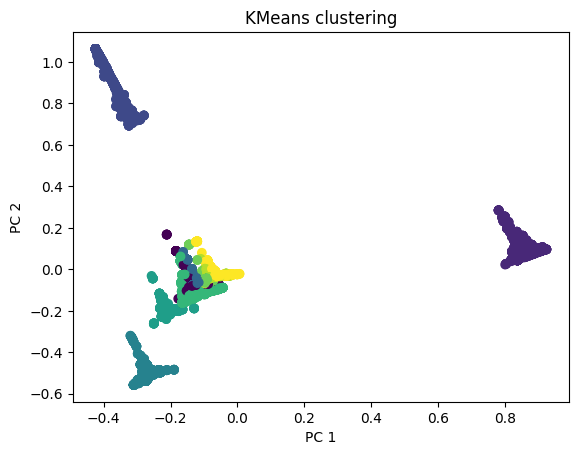

In [59]:
plt.scatter(X_proj12.iloc[:,0], X_proj12.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

Text(0.5, 0, 'k cluster number')

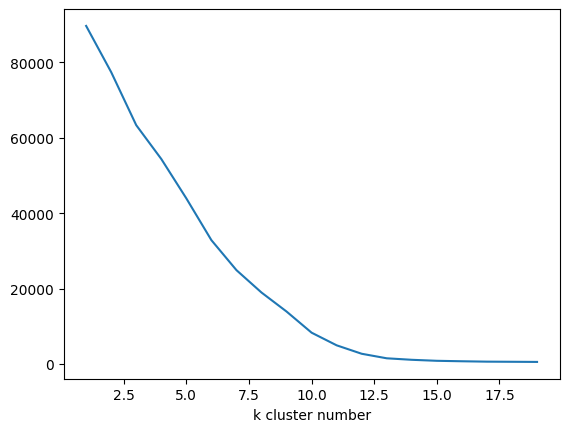

In [56]:
inertias = []
ks = range(1,20)

for k in ks:
    km_test = KMeans(n_clusters=k).fit(X_proj12)
    inertias.append(km_test.inertia_)

plt.plot(ks, inertias)
plt.xlabel('k cluster number')

In [ ]:
# km.predict(new_X)